<a href="https://colab.research.google.com/github/Malekkamoua/PFE/blob/main/.addixo/6_Generation_Classification_Interpretation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
df = pd.read_csv('/content/gdrive/MyDrive/Datascience/PFE/datasets/addixo_final_dataset_fs_db.csv', parse_dates=['dates'],  index_col='dates',infer_datetime_format=True)
df.drop(['Unnamed: 0'], axis=1, inplace=True)

In [ ]:
df.drop(['label'], axis=1, inplace=True)

In [ ]:
def create_data(series, prev_instances = 4):
 
    X_train_1 = pd.DataFrame(series).astype('float64')
    X_train_temp = X_train_1.shift(1)
    y_label = X_train_1.shift(-1)
    
    data = pd.concat([X_train_temp, X_train_1, y_label], axis=1)
    
    for r in range(prev_instances-2):
      X_train_temp = X_train_temp.shift(1)
      data = pd.concat([X_train_temp, data], axis=1)
    data.dropna(inplace = True)
    data.reset_index(drop = True, inplace = True)
    # print(data.head(10))
    X = data.iloc[:, 0:-1].values 
    y = data.iloc[:,-1].values 
        
    data.columns = [*data.columns[:-1], 'y']
    
    return data, X, y

In [ ]:
from keras.models import load_model
from keras.utils.vis_utils import plot_model

filepath = '/content/gdrive/MyDrive/Datascience/PFE/Models/transformer-best.h5'
model = load_model(filepath, compile=False)

In [ ]:
from statsmodels.tsa.stattools import acf

def forecast_accuracy(forecast, actual):
    mape = np.mean(np.abs(forecast - actual)/np.abs(actual))  
    mae = np.mean(np.abs(forecast - actual))    
    rmse = np.mean((forecast - actual)**2)**.5  

    return mape, mae, rmse

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


## 1. Generation of the new data

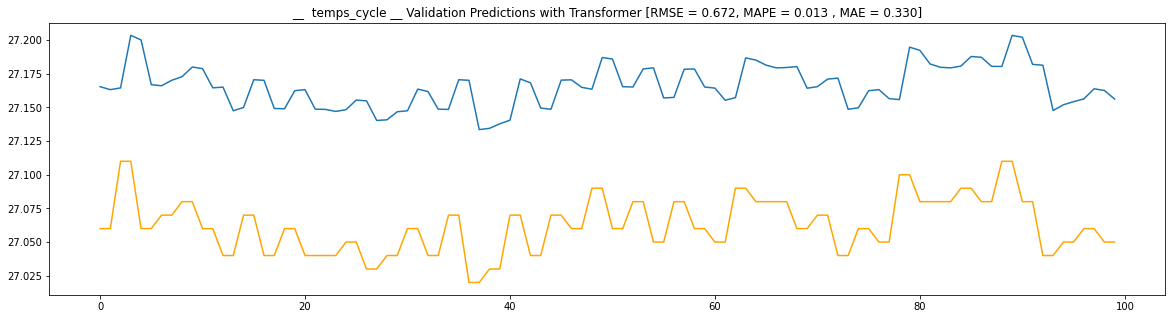

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: RuntimeWarning: divide by zero encountered in true_divide
  after removing the cwd from sys.path.


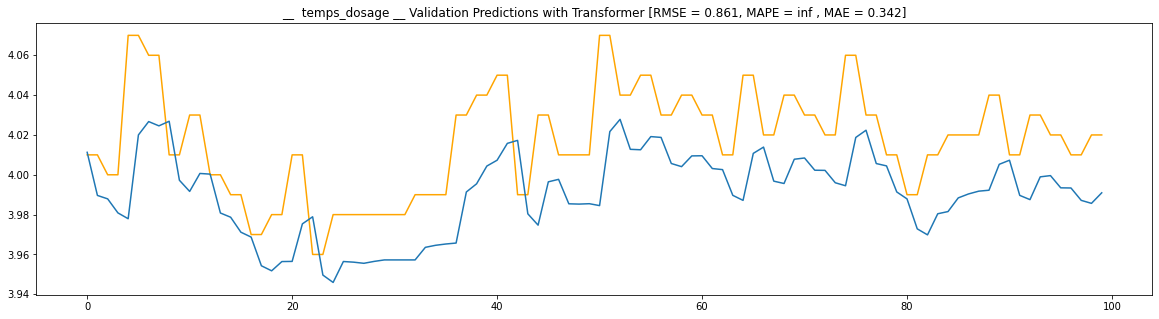

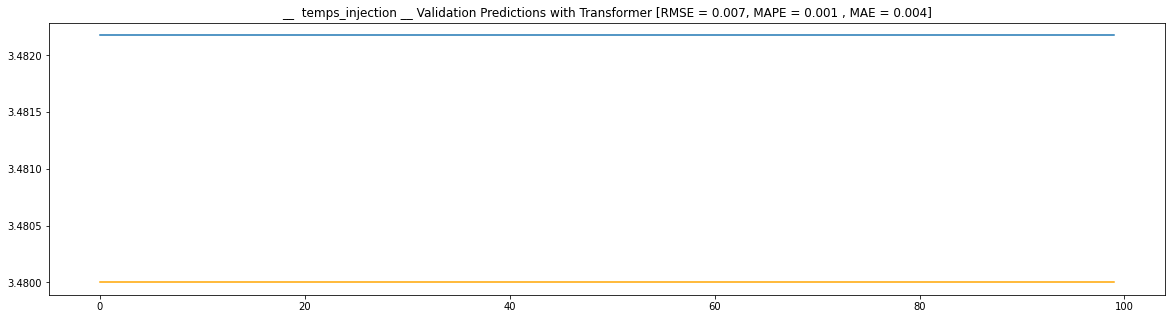

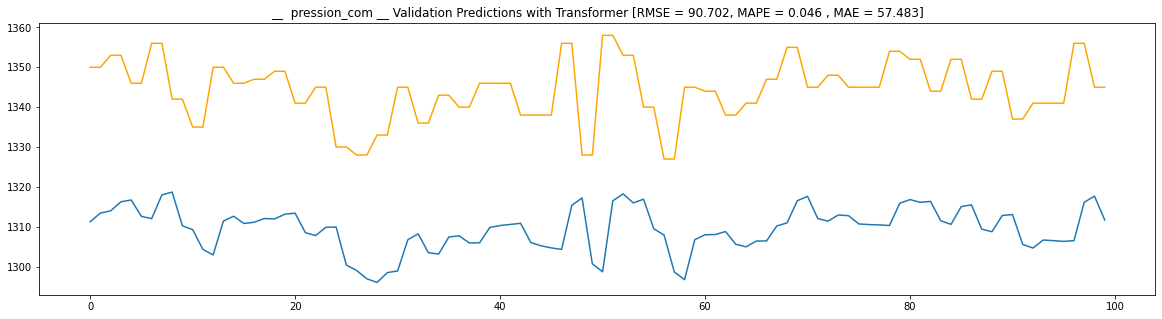

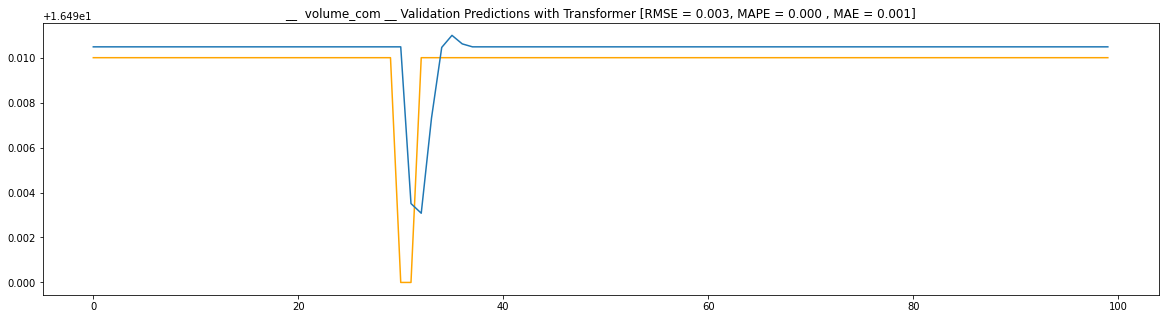

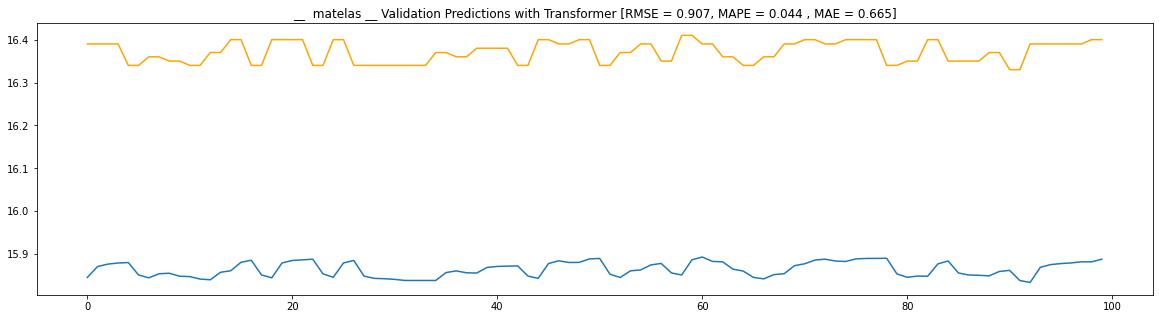

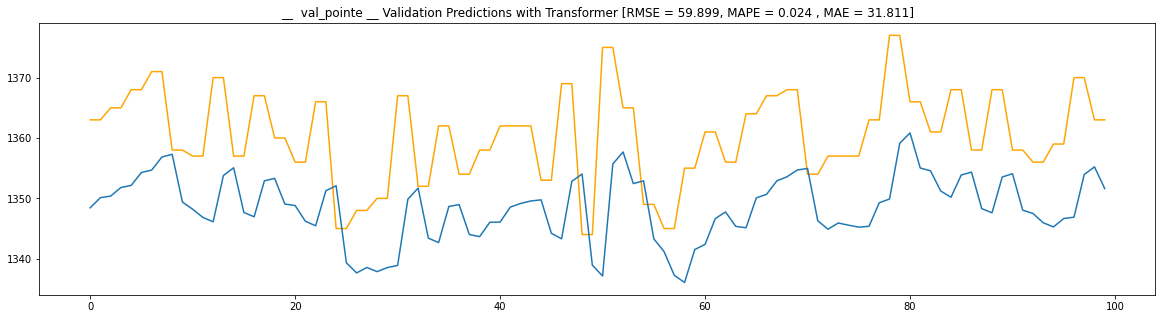

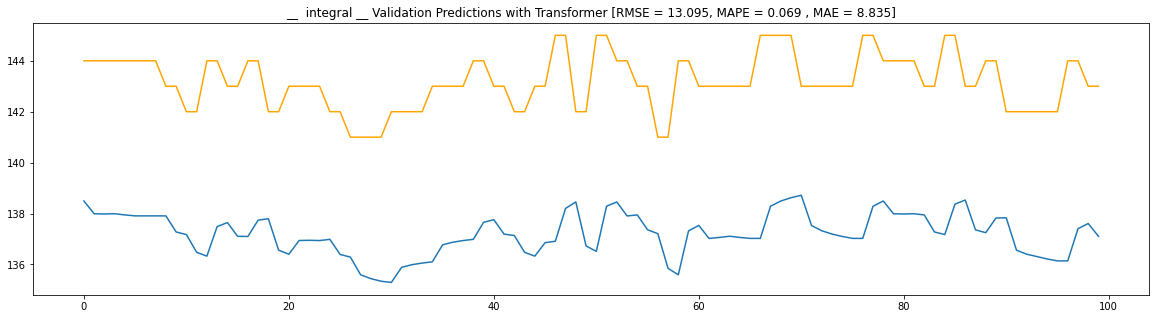

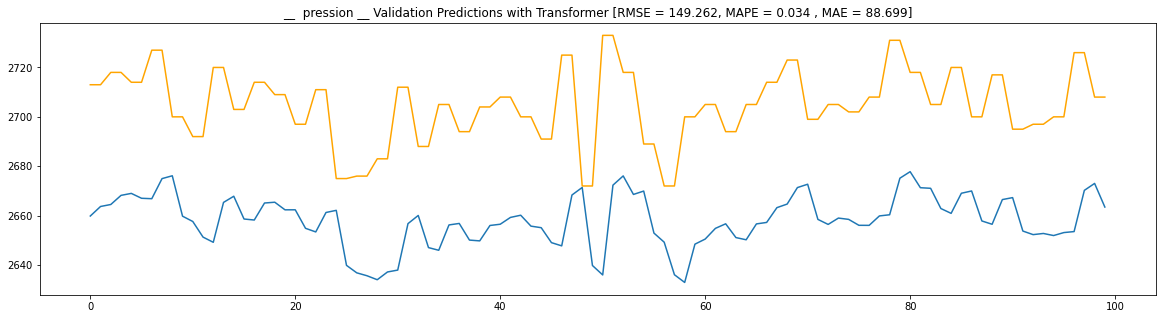

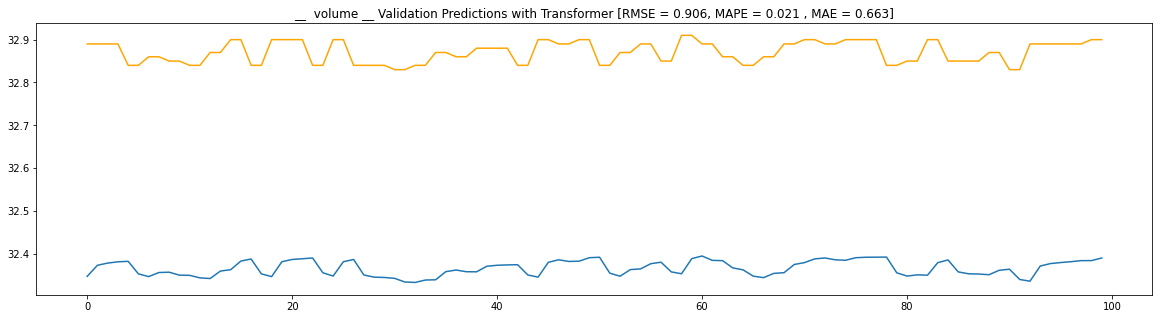

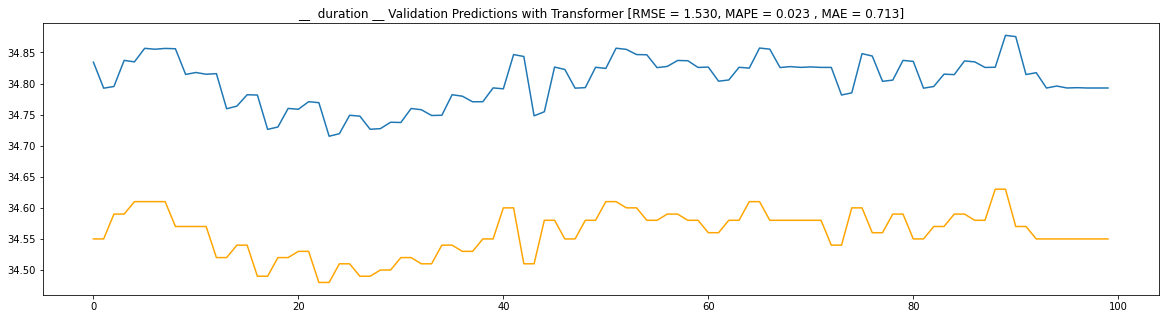

In [ ]:
from pandas._libs.lib import count_level_2d
from sklearn.preprocessing import MinMaxScaler

new_data = []
predictions = []
final_df = pd.DataFrame(new_data)
i = -1

for col in df.columns:
  # Normalization
  values = df[[col]].values

  # Normalization
  scaler = MinMaxScaler()
  scaled_data = scaler.fit_transform(values)

  WINDOW_SIZE = 5

  time_series = scaled_data;
  data, X, y = create_data(time_series, prev_instances = WINDOW_SIZE)

  # 70% 15% 15%

  X_train_tr, y_train_tr = X[:57153], y[:57153]
  X_test, y_test = X[57153:69400], y[57153:69400]
  X_val, y_val = X[69400:], y[69400:]

  import tensorflow as tf 

  BATCH_SIZE = 256
  BUFFER_SIZE = 10000

  train_univariate = tf.data.Dataset.from_tensor_slices((X_train_tr, y_train_tr))
  train_univariate = train_univariate.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()

  val_univariate = tf.data.Dataset.from_tensor_slices((X_val, y_val))
  val_univariate = val_univariate.batch(BATCH_SIZE).repeat()

  # reshape input to be 3D [samples, timesteps, features]
  X_train_tr = X_train_tr.reshape((X_train_tr.shape[0], WINDOW_SIZE,1))
  X_test = X_test.reshape((X_test.shape[0], WINDOW_SIZE, 1))
  X_val = X_val.reshape((X_val.shape[0], WINDOW_SIZE, 1))
      

  y_pred_val = model.predict(np.asarray(X_val).astype('float32'))
  Inverse_y_pred_val = scaler.inverse_transform(y_pred_val)

  Inverse_y_val = y_val.reshape(-1,1)
  Inverse_y_val = scaler.inverse_transform(Inverse_y_val)
  
  Inverse_X_val = X_val.reshape(-1,1)
  Inverse_X_val = scaler.inverse_transform(Inverse_X_val)

  
  new_col = []
  for val in Inverse_y_pred_val:
    new_col.append(val[0])

  final_df.insert(i+1,col ,new_col)

  mape, mae, rmse = forecast_accuracy(Inverse_y_pred_val, Inverse_y_val)

  fig, ax = plt.subplots(figsize=(20,5))
  plt.plot(Inverse_y_val[0:100], color='orange')
  plt.plot(Inverse_y_pred_val[0:100])
  plt.title("__  %s __ Validation Predictions with Transformer [RMSE = %.3f, MAPE = %.3f , MAE = %.3f]" % (col, rmse, mape, mae) )
  plt.show()

In [ ]:
def create_time_steps(length):
    return list(range(-length, 0))
    
def show_plot(plot_data, delta, title):
    labels = ['History', 'True Future', 'Model Prediction']
    marker = ['.-', 'rx', 'go']
    time_steps = create_time_steps(plot_data[0].shape[0])
    if delta:
        future = delta
    else:
        future = 0

    plt.title(title)
    for i, x in enumerate(plot_data):
        if i:
            plt.plot(future, plot_data[i], marker[i], markersize=10,
                   label=labels[i]);
        else:
            plt.plot(time_steps, plot_data[i].flatten(), marker[i], label=labels[i])
        plt.legend()
        plt.xlim([time_steps[0], (future+5)*2])
        plt.xlabel('Time-Step');
    
    return plt

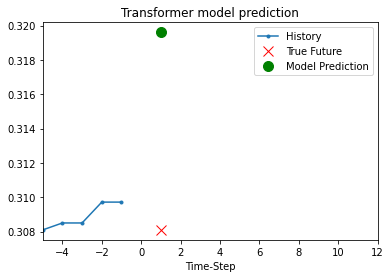

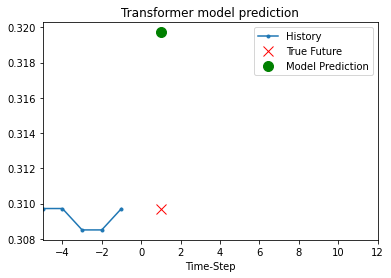

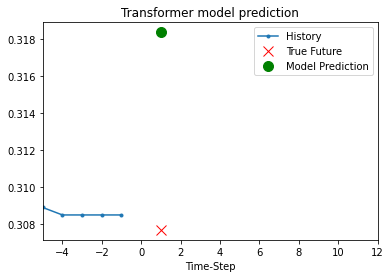

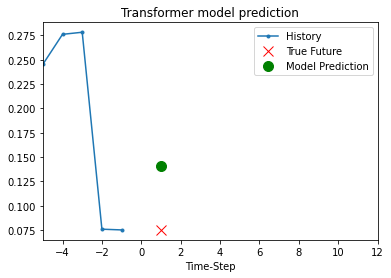

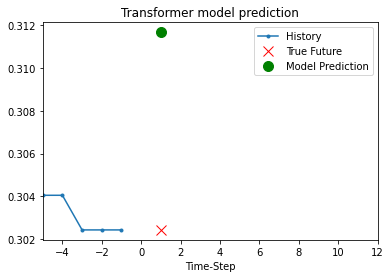

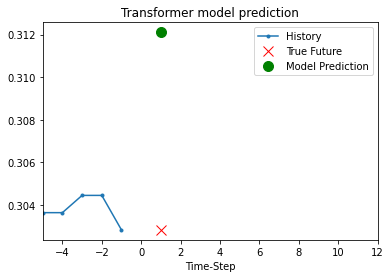

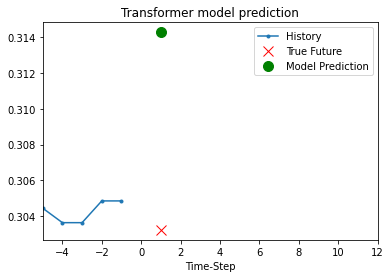

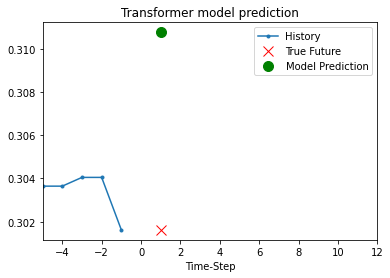

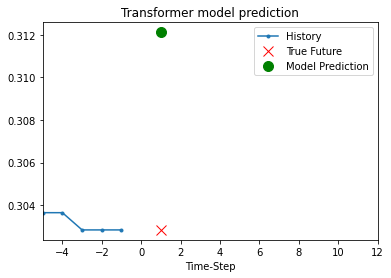

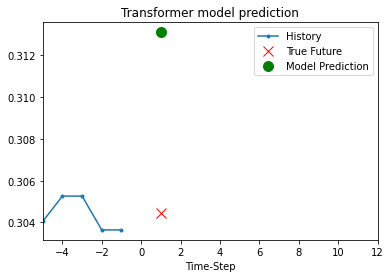

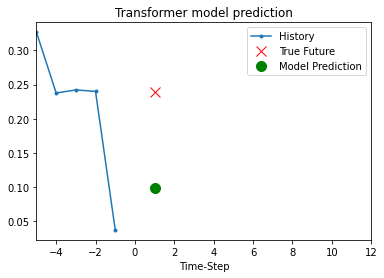

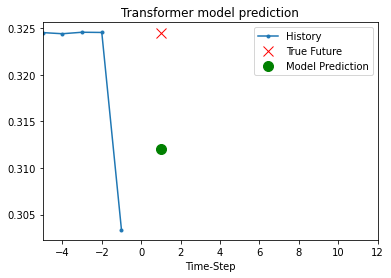

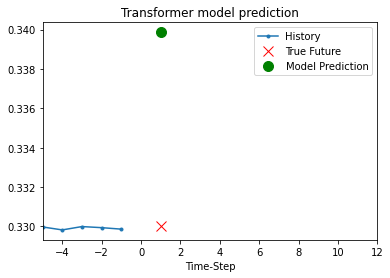

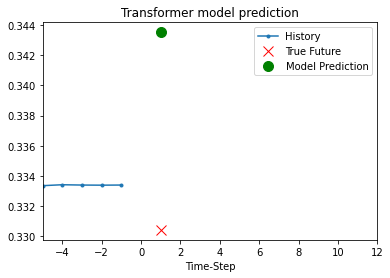

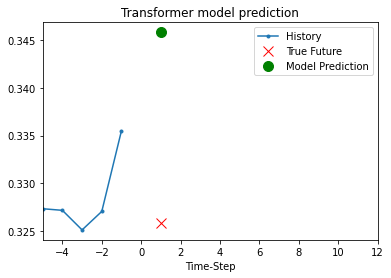

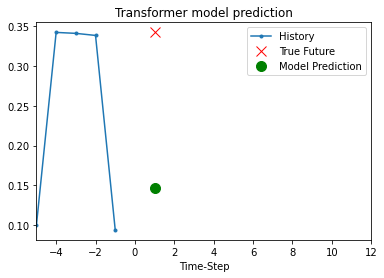

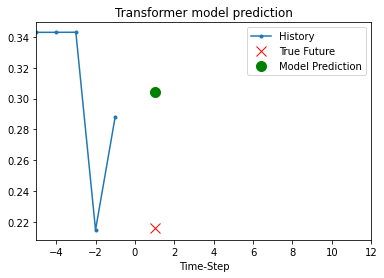

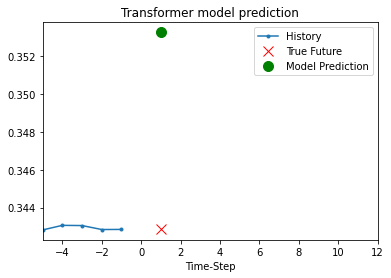

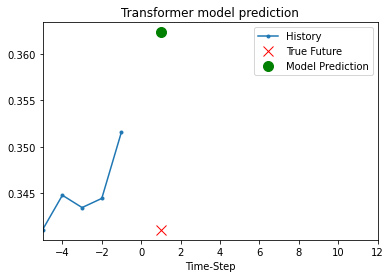

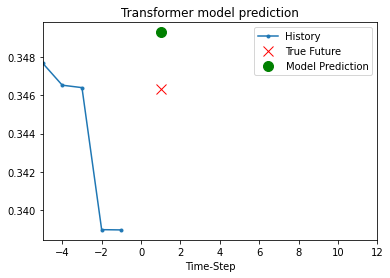

In [ ]:
for x, y in val_univariate.take(20):
    plot = show_plot([x[0].numpy(), y[0].numpy(),
                    model.predict(x)[0]], 1, 'Transformer model prediction')
    plot.show()

## 2. Classification

In [ ]:
for col in final_df:
  final_df[col] =final_df[col].apply(lambda x: round(x, 3))

In [ ]:
final_df.columns

Index(['duration', 'volume', 'pression', 'integral', 'val_pointe', 'matelas',
       'volume_com', 'pression_com', 'temps_injection', 'temps_dosage',
       'temps_cycle'],
      dtype='object')

In [ ]:
import pickle

filename = '/content/gdrive/MyDrive/Datascience/PFE/addixo_knn_classifier.sav'
loaded_model = pickle.load(open(filename, 'rb'))

#for testing
if {'label prediction'}.issubset(final_df.columns): 
  final_df.drop('label prediction', axis=1, inplace=True)

mms = MinMaxScaler()
X_val = mms.fit_transform(final_df)
result = loaded_model.predict(X_val)

final_df.insert(0,"label prediction" ,result)
final_df.head()

,label prediction,duration,volume,pression,integral,val_pointe,matelas,volume_com,pression_com,temps_injection,temps_dosage,temps_cycle
0,1,34.834,32.348,2659.832,138.492,1348.435,15.846,16.5,1311.266,3.482,4.011,27.165
1,1,34.793,32.373,2663.695,137.990,1350.115,15.871,16.5,1313.448,3.482,3.990,27.163
2,1,34.795,32.378,2664.501,137.982,1350.376,15.877,16.5,1313.994,3.482,3.988,27.165
3,1,34.837,32.381,2668.198,137.992,1351.796,15.879,16.5,1316.270,3.482,3.981,27.204
4,1,34.835,32.383,2668.997,137.944,1352.144,15.880,16.5,1316.721,3.482,3.978,27.200


label prediction
0    3405
1    8879
dtype: int64


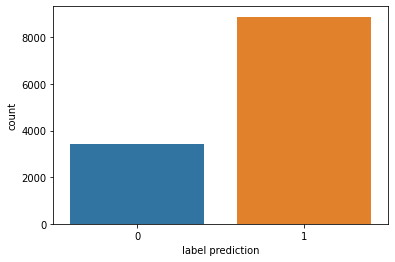

In [ ]:
import seaborn as sns

print(final_df.groupby(['label prediction']).size())
sns.countplot(x ='label prediction', data = final_df)

In [ ]:
all_dfs = [final_df]

Accuracy:  0 99.15337023770758


/usr/local/lib/python3.7/dist-packages/sklearn/base.py:444: UserWarning: X has feature names, but KNeighborsClassifier was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"


              precision    recall  f1-score   support

           0       0.99      0.98      0.99       879
           1       0.99      1.00      0.99      2192

    accuracy                           0.99      3071
   macro avg       0.99      0.99      0.99      3071
weighted avg       0.99      0.99      0.99      3071

ROC_AUC_SCORE  0.9950663494515167
_______________________________________________ 



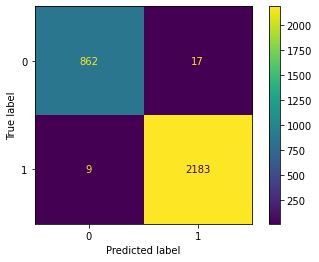

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import classification_report
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score

#initialisation
model = 0
i = 0

for df in all_dfs:
  if 'dates' in df.columns:
    X = df.drop(['label prediction', 'dates'], axis=1)
    y = df['label prediction']
  else:
    X = df.drop(['label prediction'], axis=1)
    y = df['label prediction']

  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

  grid_params = {
      'n_neighbors' : [3,5,11,19], # Always odd numbers to avaid ties
      'weights': ['uniform', 'distance'],
      'metric': ['euclidean', 'manhattan']
  }

  grid = GridSearchCV(
      KNeighborsClassifier(),
      grid_params,
      cv = 5,
      n_jobs = -1 #use all resources
  )

  grid_results = grid.fit(X_train, y_train)
  best_params = [grid_results.best_params_['metric'],grid_results.best_params_['n_neighbors'],grid_results.best_params_['weights']]

  #KNN with the best params
  model = KNeighborsClassifier(n_neighbors=best_params[1], 
                            weights=best_params[2], 
                            metric=best_params[0], 
                            n_jobs=-1)
  model.fit(X_train.values, y_train.values)
  y_test_hat=model.predict(X_test.values) 
  test_accuracy=accuracy_score(y_test,y_test_hat)*100


  print('Accuracy: ',i,test_accuracy)
  ConfusionMatrixDisplay.from_estimator(model, X_test, y_test);  
  y_pred = model.predict(X_test.values)

  print(classification_report(y_test,y_pred))

  y_pred_proba = model.predict_proba(X_test.values)[:,1]
  fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)

  print('ROC_AUC_SCORE ',roc_auc_score(y_test,y_pred_proba))
  print('_______________________________________________ \n')
  i = i + 1
  break

In [ ]:
!pip install lime

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 275 kB 5.2 MB/s 
  Created wheel for lime: filename=lime-0.2.0.1-py3-none-any.whl size=283857 sha256=b3c9d2a7e9982b668b97e8af536136d45461251894e55320f35ac261619eba00
  Stored in directory: /root/.cache/pip/wheels/ca/cb/e5/ac701e12d365a08917bf4c6171c0961bc880a8181359c66aa7
Successfully built lime


In [ ]:
import random
from sklearn.model_selection import train_test_split

X = final_df.drop(['label prediction'], axis=1)
y = final_df['label prediction']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

In [ ]:
import lime
from lime import lime_tabular

interpretor = lime_tabular.LimeTabularExplainer(
    training_data=X_train.values,
    feature_names=X_train.columns,
    mode='classification'
)

In [ ]:
random_sample = X_test.iloc[random.randrange(0, (len(X_test)-1))]

exp = interpretor.explain_instance(
    data_row=random_sample,
    predict_fn=model.predict_proba,
)

exp.show_in_notebook(show_table=True)

In [ ]:
exp.as_list()

[('pression <= 2642.51', 0.2673686379086602),
 ('integral <= 134.33', 0.2221852237636274),
 ('val_pointe <= 1340.62', 0.13133675976663314),
 ('pression_com <= 1301.45', -0.05370123180366824),
 ('duration <= 34.64', 0.04111840423780134),
 ('temps_dosage <= 3.97', 0.03261193172568915),
 ('temps_cycle <= 27.03', 0.01566785875326768),
 ('matelas <= 15.80', -0.015618251717741017),
 ('volume_com <= 16.50', -0.011809914054015219),
 ('volume <= 32.30', -0.010228183241136383)]

In [ ]:
f = open("report.txt", "a")
for i in range(0, len(exp.as_list())):
  f.write((exp.as_list())[i][0] +"\n")

f.write("\nEND FILE")
f.close()

#open and read the file after the appending:
f = open("report.txt", "r")
print(f.read())

pression <= 2642.51
integral <= 134.33
val_pointe <= 1340.62
pression_com <= 1301.45
duration <= 34.64
temps_dosage <= 3.97
temps_cycle <= 27.03
matelas <= 15.80
volume_com <= 16.50
volume <= 32.30

END FILE


## 3. Interpretation

Intuitively, an explanation is a local linear approximation of the model's behaviour. While the model may be very complex globally, it is easier to approximate it around the vicinity of a particular instance. While treating the model as a black box, we perturb the instance we want to explain and learn a sparse linear model around it, as an explanation.